# Dimensionality Reduction

## Motivation

Feature matrices of surface protein markers are hard to grasp for humans as raw tables.
Therefore, we resort to low dimensional embeddings that allow us to visualize the ADTs in commonly two dimensions.
The approaches that we use and recommend for ADT data do not differ from the ones for transcriptomics data.
All aforementioned limitations of visualizations obtained through methods like t-SNE and UMAP also apply to ADT data.

ADT data generally does not require any sophisticated feature selection, because features have already been selected a *priori* during experimental design.
All selected ADT should correspond to biologically relevant features.
Nevertheless, large datasets may benefit from PCA to reduce the dataset from several hundred features to a couple of principal components.
This is especially advisable if computational resources are limited.

## Environment setup

In [1]:
import muon as mu
import pandas as pd
import pooch
import scanpy as sc

# setting visualization parameters
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

## Loading the data

In [2]:
cite_xdbt = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/41452434",
    fname='cite_doublet_removal_xdbt.h5mu', path='.',
    known_hash=None, progressbar=True, 
)

We are simply loading the saved MuData object from the normalization chapter back in.

In [4]:
mdata = mu.read('cite_doublet_removal_xdbt.h5mu')

As the isotypes do not contain any biological information, we can remove them from our data.

In [5]:
mdata["prot"].var.index[:50]

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1', 'CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1',
       'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7-1', 'CD105', 'CD49f',
       'CD194', 'CD4-1', 'CD44-1', 'CD14-1', 'CD16', 'CD25', 'CD45RO', 'CD279',
       'TIGIT-1', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b',
       'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5-1', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69-1', 'CD62L', 'CD161'],
      dtype='object')

In [6]:
isotype_controls = ["Mouse-IgG1", "Mouse-IgG2a", "Mouse-IgG2b", "Rat-IgG2b"]

In [7]:
temp = (
    mdata["prot"]
    .var.loc[~mdata["prot"].var.index.isin(isotype_controls), :]
    .index
)
temp

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E-1', 'CD82-1',
       'CD101-1', 'CD88', 'CD224'],
      dtype='object', length=136)

We store the isotype data as a multi-dimensional annotation.

In [8]:
mdata["prot"].obsm["X_isotypes"] = mdata["prot"].X[
    :, ~mdata["prot"].var.index.isin(temp.tolist())
]

In [9]:
mu.pp.filter_var(data=mdata["prot"], var=temp.tolist())

In [10]:
mdata["prot"].var.index[:50]

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1', 'CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1',
       'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7-1', 'CD105', 'CD49f',
       'CD194', 'CD4-1', 'CD44-1', 'CD14-1', 'CD16', 'CD25', 'CD45RO', 'CD279',
       'TIGIT-1', 'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM',
       'CD5-1', 'CD195', 'CD32', 'CD196', 'CD185', 'CD103', 'CD69-1', 'CD62L',
       'CD161', 'CD152', 'CD223', 'KLRG1-1', 'CD27-1'],
      dtype='object')

## PCA and UMAP

We can now reduce the dimensionality of the data with PCA since our dataset is very big, compute a neighborhood graph and a UMAP embedding to visualize the study's variables.

In [11]:
sc.pp.pca(mdata["prot"], svd_solver="arpack")

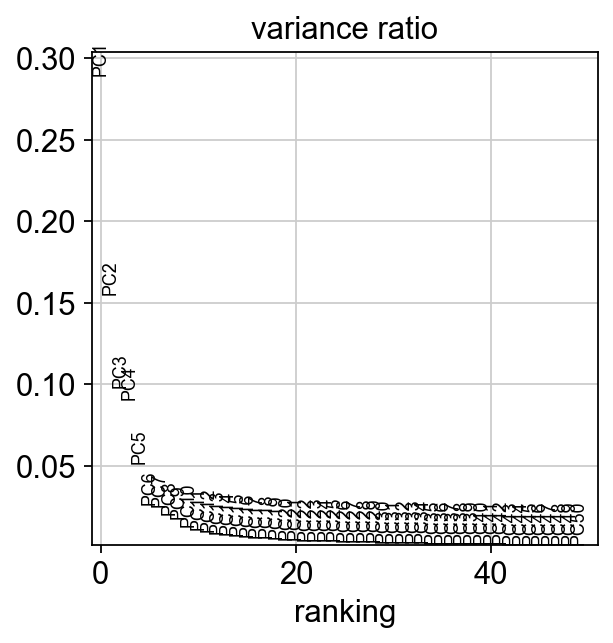

In [12]:
sc.pl.pca_variance_ratio(mdata["prot"], n_pcs=50)

In [13]:
sc.pp.neighbors(mdata["prot"], n_pcs=20)

In [14]:
sc.tl.umap(mdata["prot"])

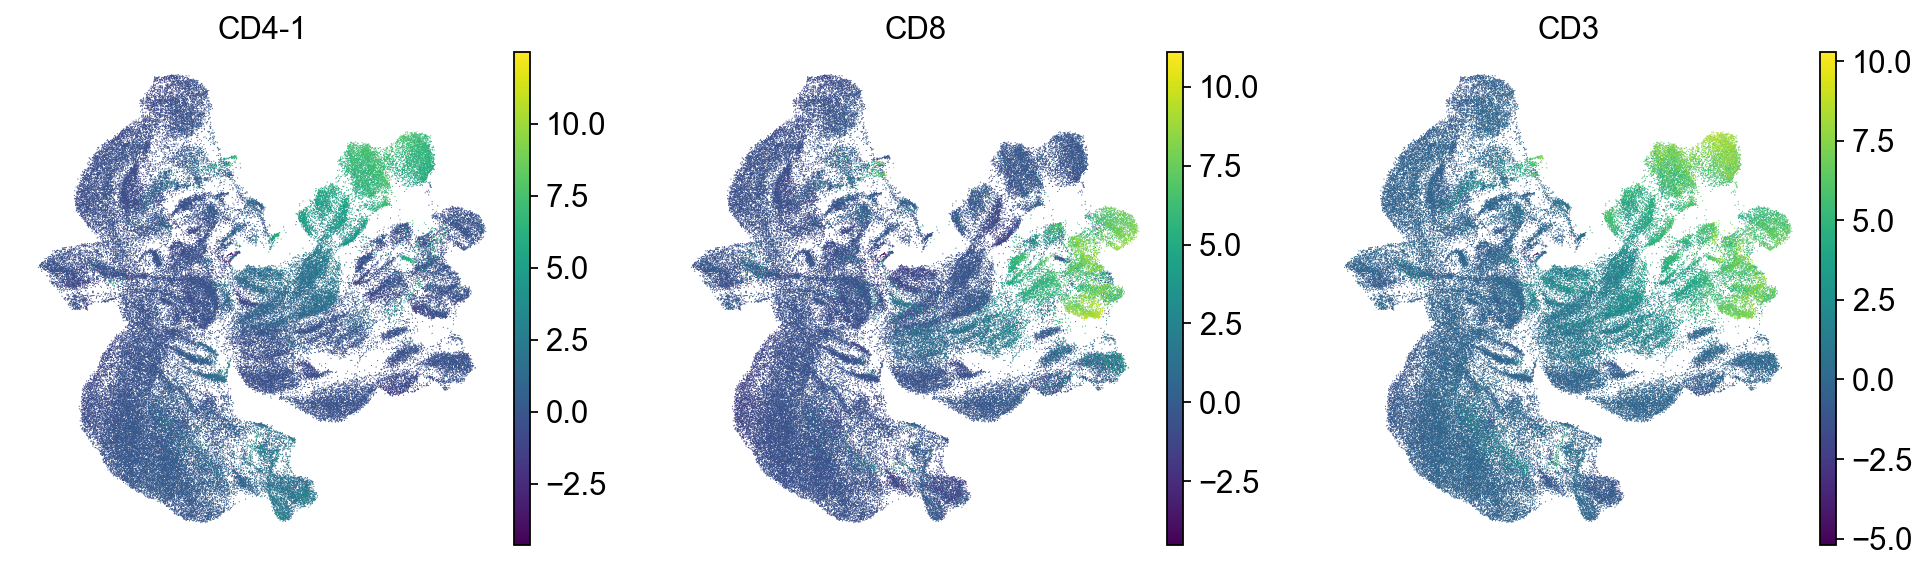

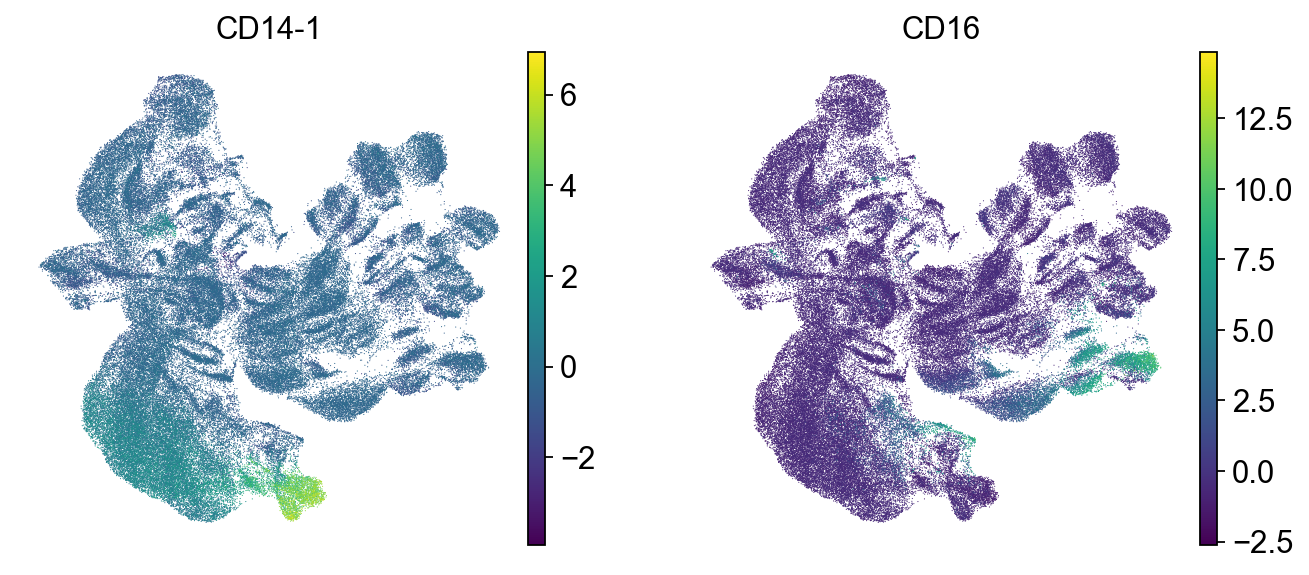

In [15]:
sc.pl.umap(mdata["prot"], color=["CD4-1", "CD8", "CD3"])
sc.pl.umap(mdata["prot"], color=["CD14-1", "CD16"])

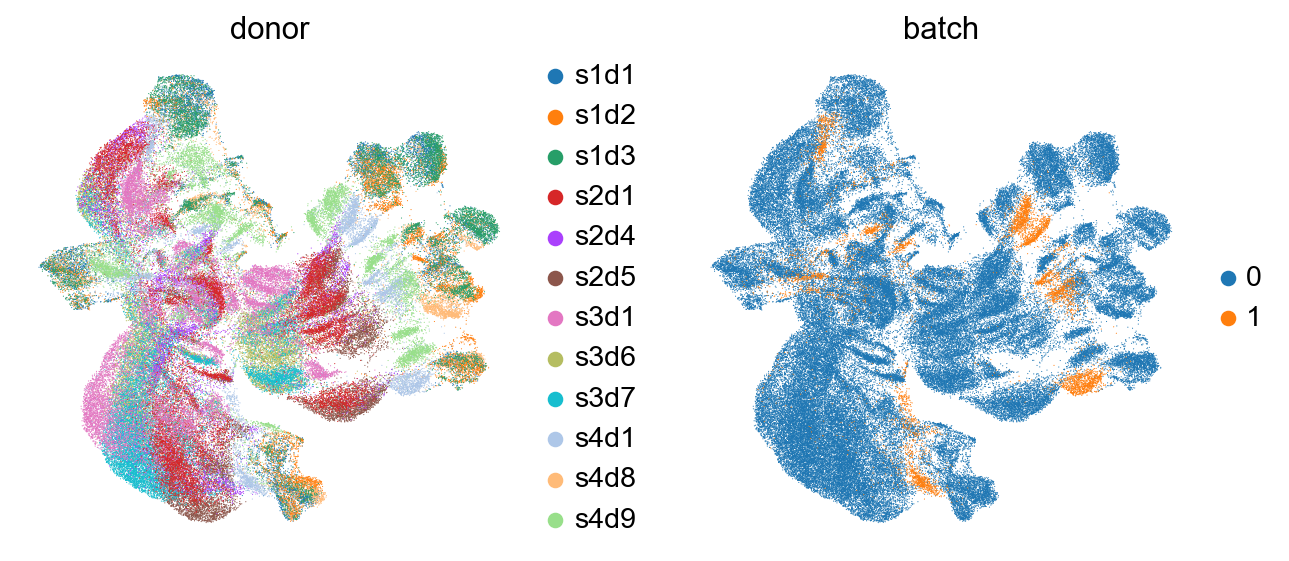

In [16]:
sc.pl.umap(mdata["prot"], color=["donor", "batch"])

As it can be seen in the above UMAP representation, different samples cluster apart from each other for similar populations (see CD4 and CD8 expression in the previous plot). Thus, batch correction of the data would be necessary.

In [17]:
mdata

MuData object with n_obs × n_vars = 119837 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	119837 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	119837 x 136
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors', 'pca', 'neighbors', 'umap', 'donor_colors', 'batch_colors'
      obsm:	'X_isotypes', 'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

In [18]:
mdata.write('cite_dimensionality_reduction.h5mu')

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Daniel Strobl
* Ciro Ramírez-Suástegui

### Reviewers

* Lukas Heumos
* Anna Schaar